# Imports

In [1]:
import json
import requests

from datetime import datetime

import pandas as pd
import numpy as np
from geopy.distance import distance

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Query GraphQL

In [2]:
def query_graphql(start_time: int, end_time: int, route: str) -> list:
    query = f"""{{
        trynState(agency: "muni",
                  startTime: "{start_time}",
                  endTime: "{end_time}",
                  routes: ["{route}"]) {{
            agency
            startTime
            routes {{
                stops {{
                    sid
                    lat
                    lon
                }}
                routeStates {{
                    vtime
                    vehicles {{
                        vid
                        lat
                        lon
                        did
                    }}
                }}
            }}
        }}
    }}
    """
    query_url = f"https://06o8rkohub.execute-api.us-west-2.amazonaws.com/dev/graphql?query={query}"

    return requests.get(query_url).json()['data']['trynState']['routes']

# Produce Datatables

In [3]:
def produce_stops(data: list) -> pd.DataFrame:
    stops = pd.io.json.json_normalize(data,
                                      record_path=['stops']) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'sid': 'SID'}) \
            .reindex(['SID', 'LAT', 'LON'], axis='columns')
    # obtain stop directions
    stops['DID'] = stops['SID'].map({stop: direction['id']
                                     for direction in requests
                                                      .get("http://restbus.info/api/agencies/sf-muni/"
                                                           f"routes/{route}")
                                                      .json()['directions']
                                     for stop in direction['stops']})
    # remove stops that don't have an associated direction
    return stops.dropna(axis='index', subset=['DID'])

In [4]:
def produce_buses(data: list) -> pd.DataFrame:
     return pd.io.json.json_normalize(data,
                                      record_path=['routeStates', 'vehicles'],
                                      meta=[['routeStates', 'vtime']]) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'vid': 'VID',
                             'did': 'DID',
                             'routeStates.vtime': 'TIME'}) \
            .reindex(['TIME', 'VID', 'LAT', 'LON', 'DID'], axis='columns')

# Eclipses

In [5]:
def show_stop(buses, stop):
    eclipses = buses.copy()

    eclipses['DIST'] = eclipses.apply(lambda bus: distance(stop[['LAT', 'LON']],
                                                           bus[['LAT', 'LON']]).meters,
                                      axis='columns')
    eclipses['TIME'] = eclipses['TIME'].astype(int)
    eclipses = eclipses[['TIME', 'VID', 'DIST']]
    
    # only keep positions within 500 meters
    eclipses = eclipses[eclipses['DIST'] < 500]

    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111)
    
    disjoint_eclipses = []
    # split bus continuity when it returns to stop after completing route
    for bus_id in eclipses['VID'].unique():
        # obtain distance data for this bus
        bus = eclipses[eclipses['VID'] == bus_id].sort_values('TIME')[['TIME', 'DIST']]

        # split data into groups when there is at least a half-hour gap between data points
        group_ids = (bus['TIME'] > (bus['TIME'].shift() + 30*60*1000)).cumsum()

        # store groups
        for _, group in bus.groupby(group_ids):
            disjoint_eclipses.append((bus_id, group.values.T))

    for bus_id, values in disjoint_eclipses:
        plt.plot(*values)

    # format plot
    ax.get_xaxis().set_major_formatter(  # convert x-axis tick labels to time of day
        FuncFormatter(lambda x, p: datetime.utcfromtimestamp(int(x)//1000).strftime('%I:%M%p')))
    plt.title(f"Eclipses at Stop {stop_id}"
              f" from {datetime.utcfromtimestamp(int(start_time)//1000).strftime('%a %I:%M%p')}"
              f" to {datetime.utcfromtimestamp(int(end_time)//1000).strftime('%a %I:%M%p')}")
    plt.xlabel("Time")
    plt.ylabel("Distance from Stop (meters)")

    plt.show()

# Hardcore Data Science

In [6]:
route = "14"

dates = [(10, 15),
         (10, 16),
         (10, 17),
         (10, 18),
         (10, 19),
         
         (10, 22),
         (10, 23),
         (10, 24),
         (10, 25),
         (10, 26),
         
         (10, 29),
         (10, 30),
         (10, 31),
         (11,  1),
         (11,  2)]

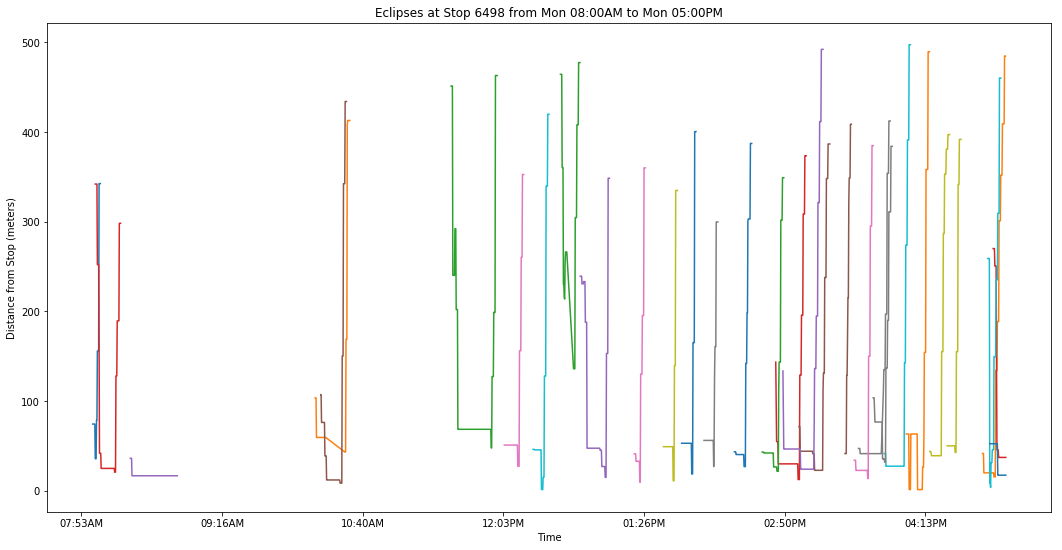

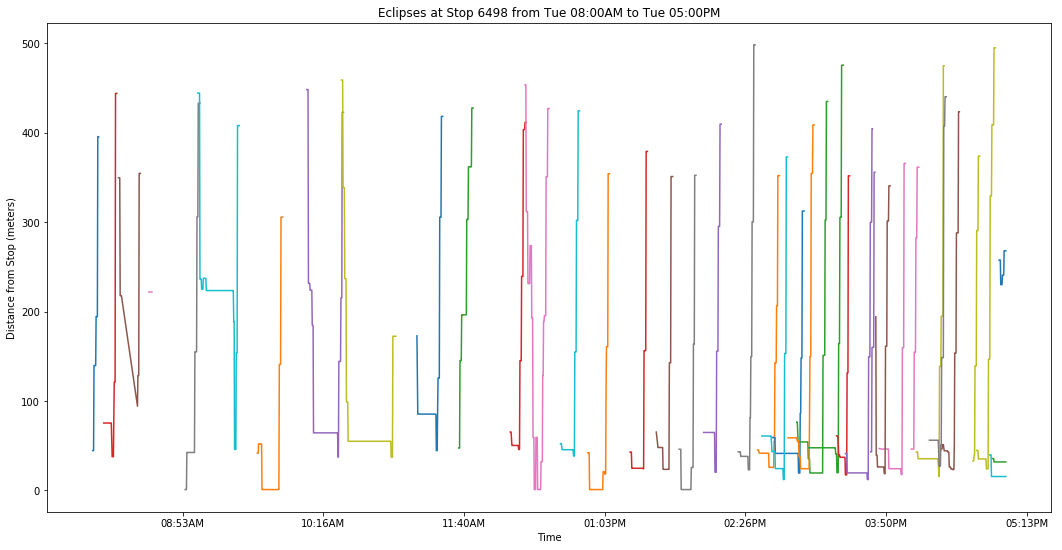

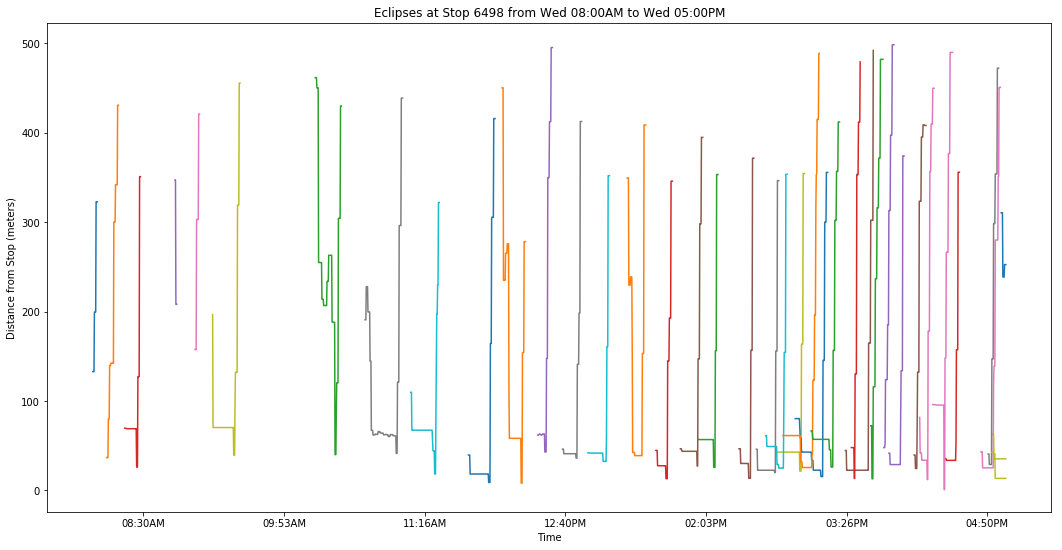

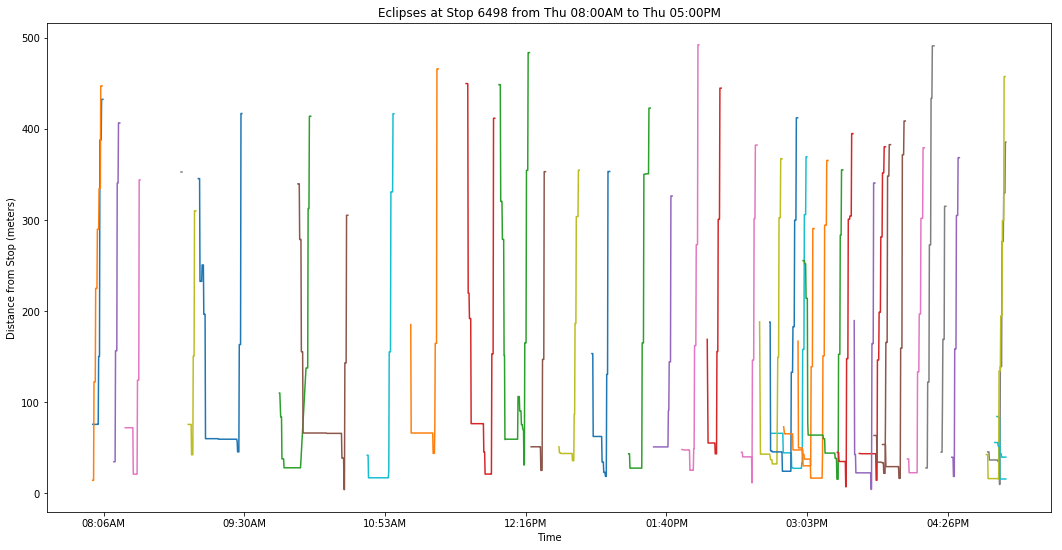

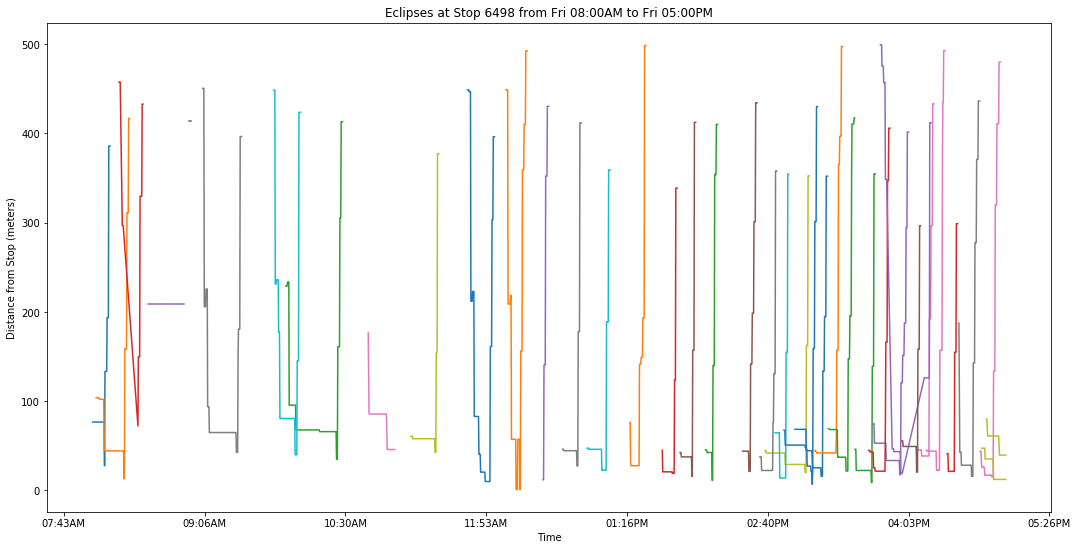

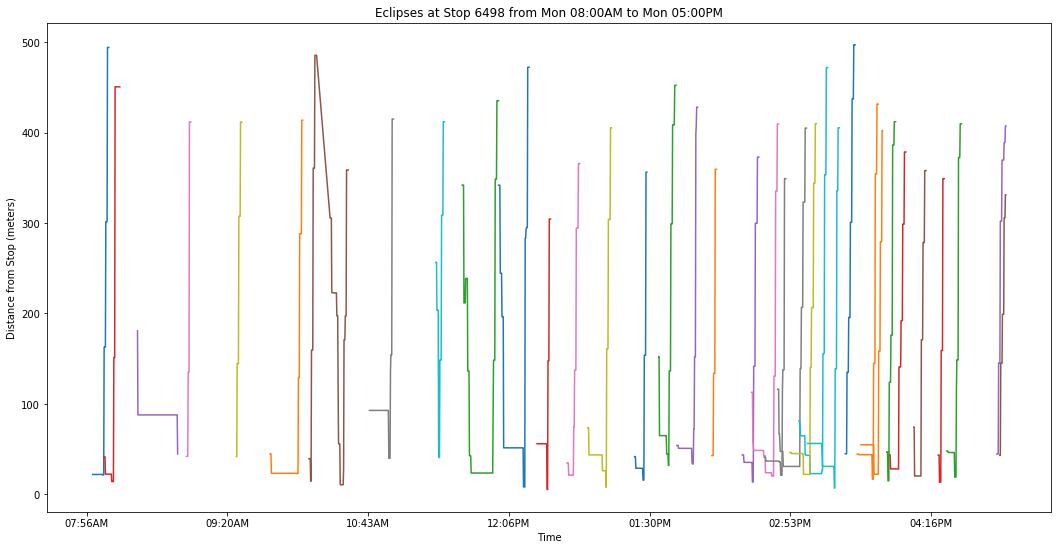

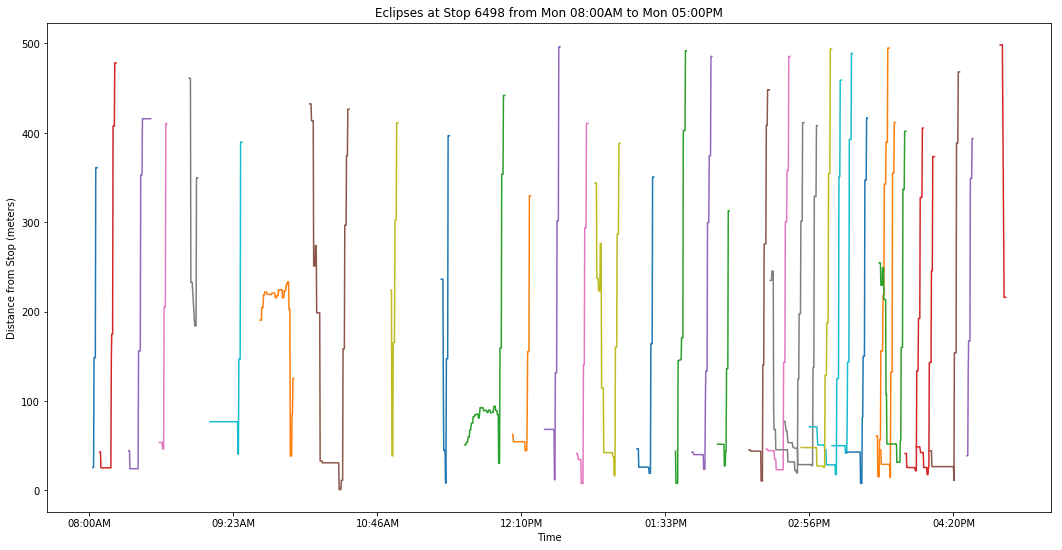

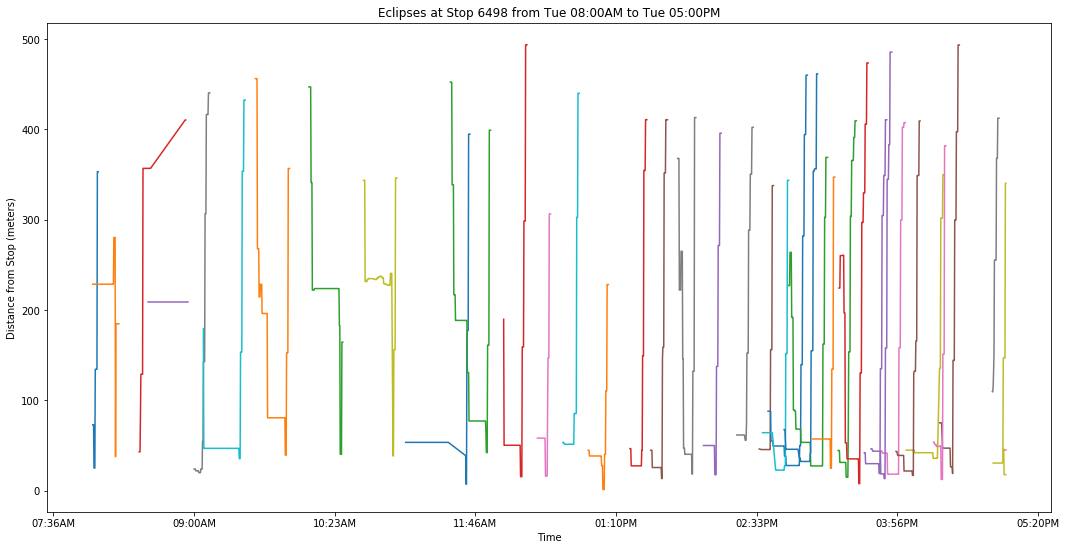

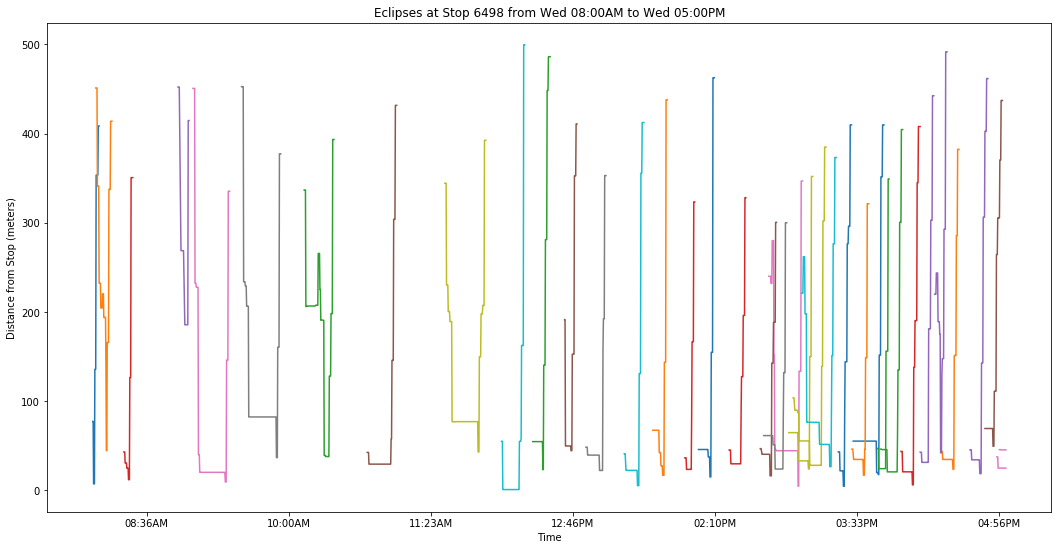

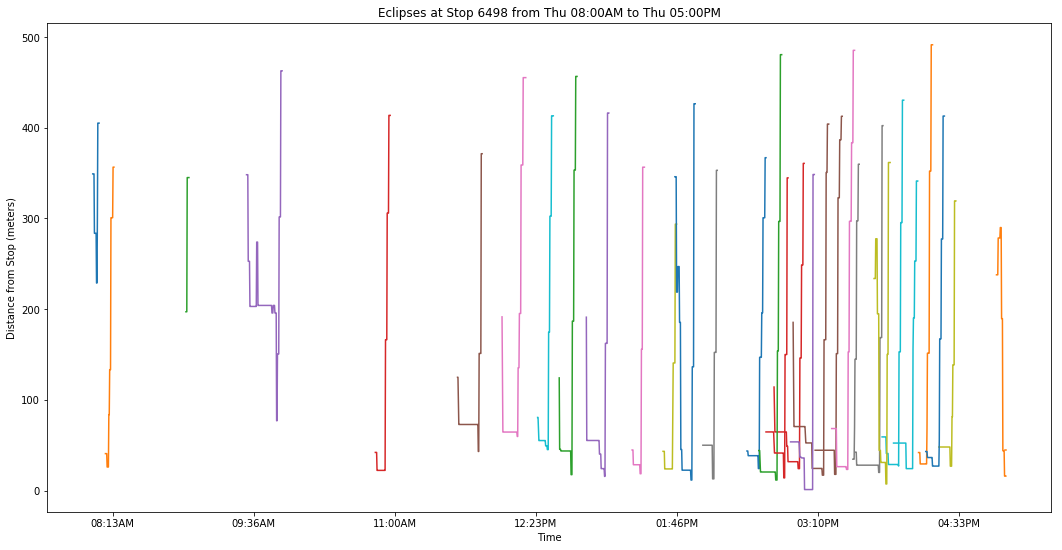

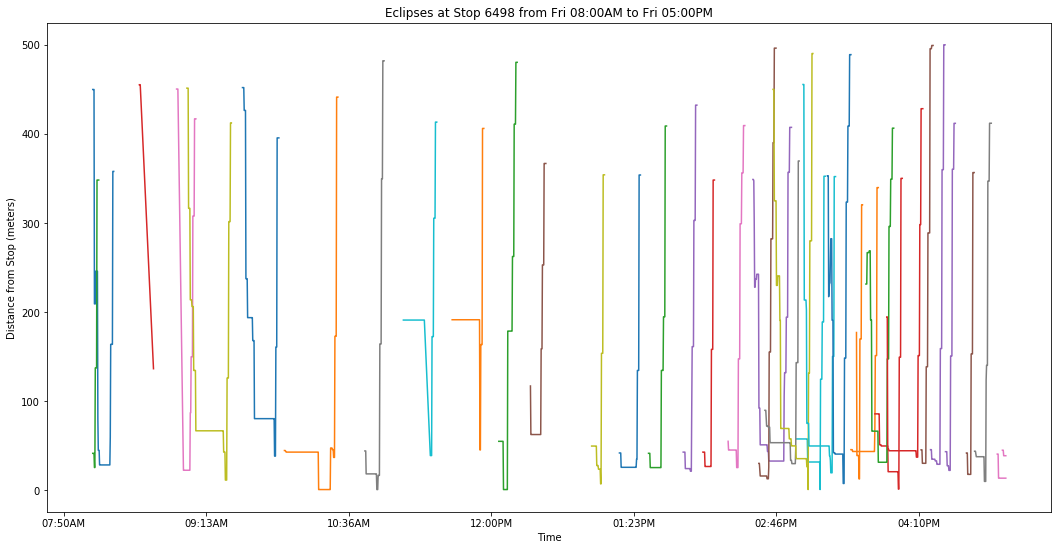

In [7]:
# grab an arbitrary stop to look at
stop_id = requests.get(f"http://restbus.info/api/agencies/sf-muni/routes/{route}").json()['stops'][0]['id']

for month, day in dates:
    start_time = int(datetime(2018, month, day,  8-7, 0, 0).timestamp())*1000
    end_time   = int(datetime(2018, month, day, 17-7, 0, 0).timestamp())*1000
    
    data = query_graphql(start_time, end_time, route)
    
    if len(data) == 0:  # some days somehow have no data
        continue
    
    stops = produce_stops(data)
    buses = produce_buses(data)

    stop = stops[stops['SID'] == stop_id].squeeze()
    buses = buses[buses['DID'] == stop['DID']]
    
    show_stop(buses, stop)